In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3 MB 1.3 MB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 3.8 MB 45.8 MB/s 
     |████████████████████████████████| 449 kB 44.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=059ae25ce654e411d3da37d31060ac41ea72389c5754720dec344dd5c69e6cab
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


end-to-end example: linear regression

In [3]:
input_dim = 2
output_dim = 1
learning_rate = 0.01

# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
  return tf.matmul(features, w) + b

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss
  

Let's generate some artificial data to demonstrate our model:

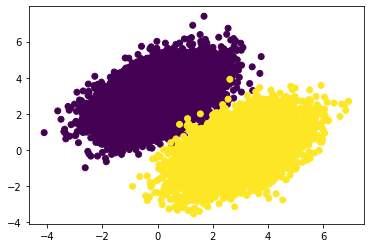

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

Now let's train our linear regression by iterating over batch-by-batch over the data and repeatedly calling train_on_batch:

In [5]:
# Shuffle the data.
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.1043
Epoch 1: last batch loss = 0.0336
Epoch 2: last batch loss = 0.0406
Epoch 3: last batch loss = 0.0254
Epoch 4: last batch loss = 0.0473
Epoch 5: last batch loss = 0.0212
Epoch 6: last batch loss = 0.0346
Epoch 7: last batch loss = 0.0202
Epoch 8: last batch loss = 0.0238
Epoch 9: last batch loss = 0.0341


Here's how our model performs:

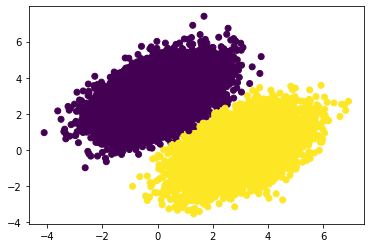

In [6]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)

Making it fast with tf.function

In [8]:
import time

t0 = time.time()
for epoch in range(20):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))


Time per epoch: 0.178 s


Let's compile the training function into a static graph. Literally all we need to do is add the tf.function decorator on it:

In [9]:
@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss


Let's try this again:

In [10]:
t0 = time.time()
for epoch in range(20):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))

Time per epoch: 0.132 s


40% reduction, neat. In this case we used a trivially simple model; in general the bigger the model the greater the speedup you can get by leveraging static graphs.

Remember: eager execution is great for debugging and printing results line-by-line, but when it's time to scale, static graphs are a researcher's best friends.

The Keras API

In [11]:
from tensorflow.keras.layers import Layer

class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32, input_dim=32):
      super(Linear, self).__init__()
      w_init = tf.random_normal_initializer()
      self.w = tf.Variable(
          initial_value=w_init(shape=(input_dim, units), dtype='float32'),
          trainable=True)
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(
          initial_value=b_init(shape=(units,), dtype='float32'),
          trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

# Instantiate our layer.
linear_layer = Linear(4, 2)

A layer instance works like a function. Let's call it on some data:

In [12]:
y = linear_layer(tf.ones((2, 2)))
assert y.shape == (2, 4)

The Layer class takes care of tracking the weights assigned to it as attributes:



In [13]:
# Weights are automatically tracked under the `weights` property.
assert linear_layer.weights == [linear_layer.w, linear_layer.b]

Note that's also a shortcut method for creating weights: add_weight. Instead of doing

In [14]:
class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b


# Instantiate our lazy layer.
linear_layer = Linear(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(tf.ones((2, 2)))
assert len(linear_layer.weights) == 2

Trainable and non-trainable weights

In [15]:
from tensorflow.keras.layers import Layer

class ComputeSum(Layer):
  """Returns the sum of the inputs."""

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # Create a non-trainable weight.
      self.total = tf.Variable(initial_value=tf.zeros((input_dim,)),
                               trainable=False)

  def call(self, inputs):
      self.total.assign_add(tf.reduce_sum(inputs, axis=0))
      return self.total  

my_sum = ComputeSum(2)
x = tf.ones((2, 2))

y = my_sum(x)
print(y.numpy())  # [2. 2.]

y = my_sum(x)
print(y.numpy())  # [4. 4.]

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []

[2. 2.]
[4. 4.]


Recursively composing layers

Layers can be recursively nested to create bigger computation blocks. Each layer will track the weights of its sublayers (both trainable and non-trainable).

In [16]:
# Let's reuse the Linear class
# with a `build` method that we defined above.

class MLP(Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)

mlp = MLP()

# The first call to the `mlp` object will create the weights.
y = mlp(tf.ones(shape=(3, 64)))

# Weights are recursively tracked.
assert len(mlp.weights) == 6

Built-in layers

The training argument in call

In [17]:
from tensorflow.keras.layers import Layer

class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

class MLPWithDropout(Layer):

  def __init__(self):
      super(MLPWithDropout, self).__init__()
      self.linear_1 = Linear(32)
      self.dropout = Dropout(0.5)
      self.linear_3 = Linear(10)

  def call(self, inputs, training=None):
      x = self.linear_1(inputs)
      x = tf.nn.relu(x)
      x = self.dropout(x, training=training)
      return self.linear_3(x)
    
mlp = MLPWithDropout()
y_train = mlp(tf.ones((2, 2)), training=True)
y_test = mlp(tf.ones((2, 2)), training=False)

A more Functional way of defining models

To build deep learning models, you don't have to use object-oriented programming all the time. Layers can also be composed functionally, like this (we call it the "Functional API"):

In [18]:
# We use an `Input` object to describe the shape and dtype of the inputs.
# This is the deep learning equivalent of *declaring a type*.
# The shape argument is per-sample; it does not include the batch size.
# The functional API focused on defining per-sample transformations.
# The model we create will automatically batch the per-sample transformations,
# so that it can be called on batches of data.
inputs = tf.keras.Input(shape=(16,))

# We call layers on these "type" objects
# and they return updated types (new shapes/dtypes).
x = Linear(32)(inputs) # We are reusing the Linear layer we defined earlier.
x = Dropout(0.5)(x) # We are reusing the Dropout layer we defined earlier.
outputs = Linear(10)(x)

# A functional `Model` can be defined by specifying inputs and outputs.
# A model is itself a layer like any other.
model = tf.keras.Model(inputs, outputs)

# A functional model already has weights, before being called on any data.
# That's because we defined its input shape in advance (in `Input`).
assert len(model.weights) == 4

# Let's call our model on some data.
y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

In [19]:
from tensorflow.keras import Sequential

model = Sequential([Linear(32), Dropout(0.5), Linear(10)])

y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

Loss classes

In [20]:
bce = tf.keras.losses.BinaryCrossentropy()
y_true = [0., 0., 1., 1.]  # Targets
y_pred = [1., 1., 1., 0.]  # Predictions
loss = bce(y_true, y_pred)
print('Loss:', loss.numpy())

Loss: 11.522857


Metric classes

In [21]:
m = tf.keras.metrics.AUC()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('Intermediate result:', m.result().numpy())

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('Final result:', m.result().numpy())

Intermediate result: 0.6666667
Final result: 0.71428573


In [22]:
class BinaryTruePositives(tf.keras.metrics.Metric):

  def __init__(self, name='binary_true_positives', **kwargs):
    super(BinaryTruePositives, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight)
    self.true_positives.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.true_positives

  def reset_states(self):
    self.true_positive.assign(0)

m = BinaryTruePositives()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('Intermediate result:', m.result().numpy())

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('Final result:', m.result().numpy())

Intermediate result: 1.0
Final result: 3.0


Optimizer classes & a quick end-to-end training loop

In [23]:
from tensorflow.keras import layers

# Prepare a dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:].reshape(60000, 784).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    logits = model(x)

    # Loss value for this batch.
    loss_value = loss(y, logits)
     
  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, model.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  # Update the running accuracy.
  accuracy.update_state(y, logits)
  
  # Logging.
  if step % 100 == 0:
    print('Step:', step)
    print('Loss from last step: %.3f' % loss_value)
    print('Total running accuracy so far: %.3f' % accuracy.result())

11493376/11490434 [==============================] - 0s 0us/step
Step: 0
Loss from last step: 2.380
Total running accuracy so far: 0.125
Step: 100
Loss from last step: 0.313
Total running accuracy so far: 0.838
Step: 200
Loss from last step: 0.108
Total running accuracy so far: 0.877
Step: 300
Loss from last step: 0.239
Total running accuracy so far: 0.896
Step: 400
Loss from last step: 0.153
Total running accuracy so far: 0.908
Step: 500
Loss from last step: 0.164
Total running accuracy so far: 0.916
Step: 600
Loss from last step: 0.123
Total running accuracy so far: 0.922
Step: 700
Loss from last step: 0.146
Total running accuracy so far: 0.927
Step: 800
Loss from last step: 0.097
Total running accuracy so far: 0.930
Step: 900
Loss from last step: 0.104
Total running accuracy so far: 0.934


We can reuse our SparseCategoricalAccuracy metric instance to implement a testing loop:

In [24]:
x_test = x_test[:].reshape(10000, 784).astype('float32') / 255
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)

accuracy.reset_states()  # This clears the internal state of the metric

for step, (x, y) in enumerate(test_dataset):
  logits = model(x)
  accuracy.update_state(y, logits)

print('Final test accuracy: %.3f' % accuracy.result())

Final test accuracy: 0.966


The add_loss method

In [25]:
from tensorflow.keras.layers import Layer

class ActivityRegularization(Layer):
  """Layer that creates an activity sparsity regularization loss."""
  
  def __init__(self, rate=1e-2):
    super(ActivityRegularization, self).__init__()
    self.rate = rate
  
  def call(self, inputs):
    # We use `add_loss` to create a regularization loss
    # that depends on the inputs.
    self.add_loss(self.rate * tf.reduce_sum(tf.square(inputs)))
    return inputs

Loss values added via add_loss can be retrieved in the .losses list property of any Layer or Model:

In [26]:
from tensorflow.keras import layers

class SparseMLP(Layer):
  """Stack of Linear layers with a sparsity regularization loss."""

  def __init__(self, output_dim):
      super(SparseMLP, self).__init__()
      self.dense_1 = layers.Dense(32, activation=tf.nn.relu)
      self.regularization = ActivityRegularization(1e-2)
      self.dense_2 = layers.Dense(output_dim)

  def call(self, inputs):
      x = self.dense_1(inputs)
      x = self.regularization(x)
      return self.dense_2(x)
    

mlp = SparseMLP(1)
y = mlp(tf.ones((10, 10)))

print(mlp.losses)  # List containing one float32 scalar

[<tf.Tensor: id=185825, shape=(), dtype=float32, numpy=0.90322995>]


These losses are cleared by the top-level layer at the start of each forward pass -- they don't accumulate. So layer.losses always contain only the losses created during the last forward pass. You would typically use these losses by summing them before computing your gradients when writing a training loop.

In [27]:
# Losses correspond to the *last* forward pass.
mlp = SparseMLP(1)
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 1
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 1  # No accumulation.

# Let's demonstrate how to use these losses in a training loop.

# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype('float32') / 255, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# A new MLP.
mlp = SparseMLP(10)

# Loss and optimizer.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for step, (x, y) in enumerate(dataset):
  with tf.GradientTape() as tape:
    # Forward pass.
    logits = mlp(x)

    # External loss value for this batch.
    loss = loss_fn(y, logits)
    
    # Add the losses created during the forward pass.
    loss += sum(mlp.losses)
     
    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(loss, mlp.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))
  
  # Logging.
  if step % 100 == 0:
    print('Loss at step %d: %.3f' % (step, loss))

Loss at step 0: 3.786
Loss at step 100: 2.300
Loss at step 200: 2.298
Loss at step 300: 2.295
Loss at step 400: 2.236
Loss at step 500: 2.240
Loss at step 600: 2.050
Loss at step 700: 1.969
Loss at step 800: 2.023
Loss at step 900: 1.933


A detailed end-to-end example: a Variational AutoEncoder (VAE)
If you want to take a break from the basics and look at a slightly more advanced example, check out this Variational AutoEncoder implementation that demonstrates everything you've learned so far:

1. Subclassing Layer

2. Recursive layer composition

3. Loss classes and metric classes

4. add_loss

5. GradientTape

Using built-in training loops

In [28]:
# Prepare a dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

In [29]:
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])


In [30]:
model.fit(dataset, epochs=3)

Epoch 1/3
938/938 [==============================] - 11s 12ms/step - loss: 0.2186 - sparse_categorical_accuracy: 0.9365
Epoch 2/3
938/938 [==============================] - 7s 8ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9743
Epoch 3/3
938/938 [==============================] - 8s 9ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9833


Done!

Note: When you use fit, by default execution uses static graphs, so you don't need to add any tf.function decorators to your model or your layers.

Now let's test it:

In [31]:
x_test = x_test[:].reshape(10000, 784).astype('float32') / 255
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)

loss, acc = model.evaluate(test_dataset)
print('loss: %.3f - acc: %.3f' % (loss, acc))

79/79 [==============================] - 1s 7ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9710
loss: 0.097 - acc: 0.971


Note that you can also monitor your loss and metrics on some validation data during fit.

Also, you can call fit directly on Numpy arrays, so no need for the dataset conversion:

In [32]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

num_val_samples = 10000
x_val = x_train[-num_val_samples:]
y_val = y_train[-num_val_samples:]
x_train = x_train[:-num_val_samples]
y_train = y_train[:-num_val_samples]

# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[accuracy])
model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          epochs=3,
          batch_size=64)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 6s 112us/sample - loss: 0.2400 - sparse_categorical_accuracy: 0.9279 - val_loss: 0.1102 - val_sparse_categorical_accuracy: 0.9681
Epoch 2/3
50000/50000 [==============================] - 7s 131us/sample - loss: 0.0920 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.0876 - val_sparse_categorical_accuracy: 0.9719
Epoch 3/3
50000/50000 [==============================] - 4s 85us/sample - loss: 0.0596 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.0888 - val_sparse_categorical_accuracy: 0.9737


**Callbacks**

One of the neat features of fit (besides built-in support for sample weighting and class weighting) is that you can easily customize what happens during training and evaluation by using callbacks.

A callback is an object that is called at different points during training (e.g. at the end of every batch or at the end of every epoch) and takes actions, such as saving a model, mutating variables on the model, loading a checkpoint, stopping training, etc.

There's a bunch of built-in callback available, like ModelCheckpoint to save your models after each epoch during training, or EarlyStopping, which interrupts training when your validation metrics start stalling.

And you can easily write your own callbacks.

In [33]:
# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[accuracy])

# Instantiate some callbacks
callbacks = [tf.keras.callbacks.EarlyStopping(),
             tf.keras.callbacks.ModelCheckpoint(filepath='my_model.keras',
                                                save_best_only=True)]

model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          epochs=30,
          batch_size=64,
          callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 5s 106us/sample - loss: 0.2440 - sparse_categorical_accuracy: 0.9268 - val_loss: 0.1186 - val_sparse_categorical_accuracy: 0.9654
Epoch 2/30
50000/50000 [==============================] - 4s 86us/sample - loss: 0.0921 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.0838 - val_sparse_categorical_accuracy: 0.9759
Epoch 3/30
50000/50000 [==============================] - 4s 85us/sample - loss: 0.0607 - sparse_categorical_accuracy: 0.9808 - val_loss: 0.0844 - val_sparse_categorical_accuracy: 0.9761
